# FineTuning BERT for Multi-Class Classification with custom datasets

### [Link to Dataset](https://www.kaggle.com/datasets/savasy/ttc4900)

In [ ]:
import torch, os
import pandas as pd
from transformers import pipeline, BertForSequenceClassification, BertTokenizerFast
from torch.utils.data import Dataset


In [ ]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# df_org= pd.read_csv("/content/drive/MyDrive/PRIVACY MODEL/BERT_for_Multi_Class_Classification (Privacy_Original)/combined_file.csv")


# df_org = df_org.sample(frac=1.0, random_state=42)

# df_org.head(3)

**LOADING ... FINAL DATASET FOR TRAINING**

In [ ]:
df_org= pd.read_csv("/content/drive/MyDrive/PRIVACY MODEL/PRIVACY MODEL/BERT_for_Multi_Class_Classification (Privacy_Original)/Final Dataset.csv")


df_org = df_org.sample(frac=1.0, random_state=42)

df_org.head(3)

df_org.shape

(21262, 2)

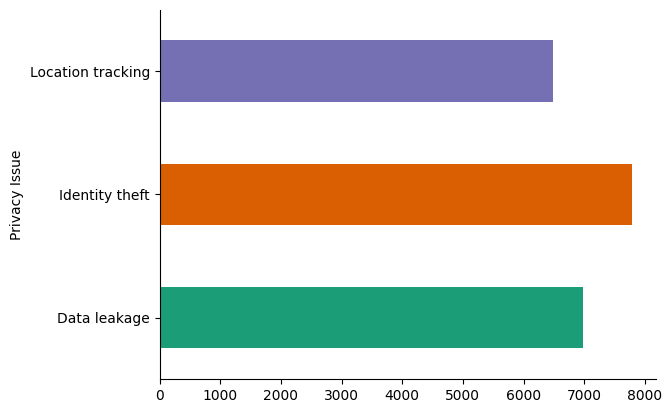

In [ ]:
# @title Privacy Issue

from matplotlib import pyplot as plt
import seaborn as sns
df_org.groupby('Privacy Issue').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# df_org=df_org[df_org["Sentiment"]=="Negative"]

# df_org.head()

# df_org.to_csv("Privacy.csv", index = False)

In [ ]:
labels = df_org['Privacy Issue'].unique().tolist()
labels = [s.strip() for s in labels ]
labels

['Identity theft', 'Location tracking', 'Data leakage']


## Why we need id2label and labe2ids in NLP Projects

In NLP tasks, especially those involving classification problems, id2label and label2id dictionaries are used to map class labels (categories) to integer IDs and vice versa. These mappings are essential for various stages of the NLP pipeline, such as data preprocessing, model training, and evaluation.

Data preprocessing: In order to feed text data into an NLP model, the text must first be tokenized and then converted into numerical values. Similarly, class labels must also be transformed into numerical representations. The label2id dictionary helps in converting the original class labels into integer IDs.

Model training: NLP models usually output probability distributions over classes as their predictions. During training, the model's predictions are compared against the ground truth labels (which have been converted to integer IDs) to compute the loss and optimize the model parameters.

Model evaluation and interpretation: Once the model has been trained, its predictions (in the form of integer IDs) need to be mapped back to their original class labels to make the results interpretable. The id2label dictionary is used to perform this conversion.


For `BertForSequenceClassification` model as well I need these exact mapping of id2labels and labels2id in dictionary form.

### Hence, fefore you start training your model, create a map of the expected ids to their labels with id2label and label2id:

In [ ]:
for key, value in enumerate(labels):
    print(value)

Identity theft
Location tracking
Data leakage


In [ ]:
NUM_LABELS= len(labels)

id2label={id:label for id,label in enumerate(labels)}

label2id={label:id for id,label in enumerate(labels)}

In [ ]:
label2id

{'Identity theft': 0, 'Location tracking': 1, 'Data leakage': 2}

In [ ]:
id2label

{0: 'Identity theft', 1: 'Location tracking', 2: 'Data leakage'}

In [ ]:
# def label_int2str(row):
# return df_org.features["Privacy Issue"].int2str(row)

In [ ]:
# df_org.drop("Sentiment", axis='columns')
df_org.head()

,Learners Perspective,Privacy Issue
13976,I foolishly use my debit card for online purch...,Identity theft
1710,Mobile apps associated with the eLearning plat...,Location tracking
369,"During the upload of lecture materials, an in...",Location tracking
1698,I have concerns about the privacy features in ...,Data leakage
13540,My wife's identity was stolen because she was ...,Identity theft


### Create a new column to represent the categories in numerical form

I need a 'label' column heading with numeric value else while running the epochs with `trainer.train()` I will get below error

```
BertForSequenceClassification ValueError: The model did not return

```


### In below I am doing it manually, but I could have also done it with pd.factorize() as below

Pandas factorize method is used for encoding categorical variables as integers. It assigns a unique integer value to each distinct category in a given Series or DataFrame, effectively transforming non-numeric data into numeric values.

In [ ]:
# df_org['labels_num'] = pd.factorize(df_org.category)[0]
# df_org.head()

In [ ]:
df_org["labels"]=df_org["Privacy Issue"].map(lambda x: label2id[x.strip()])

In [ ]:
df_org.head()

,Learners Perspective,Privacy Issue,labels
13976,I foolishly use my debit card for online purch...,Identity theft,0
1710,Mobile apps associated with the eLearning plat...,Location tracking,1
369,"During the upload of lecture materials, an in...",Location tracking,1
1698,I have concerns about the privacy features in ...,Data leakage,2
13540,My wife's identity was stolen because she was ...,Identity theft,0


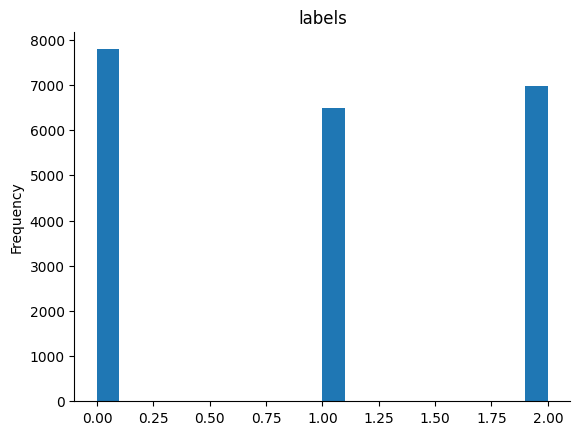

In [ ]:
# @title labels

from matplotlib import pyplot as plt
df_org['labels'].plot(kind='hist', bins=20, title='labels')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
df_org['Privacy Issue'].value_counts()

,count
Privacy Issue,
Identity theft,7789
Data leakage,6983
Location tracking,6490


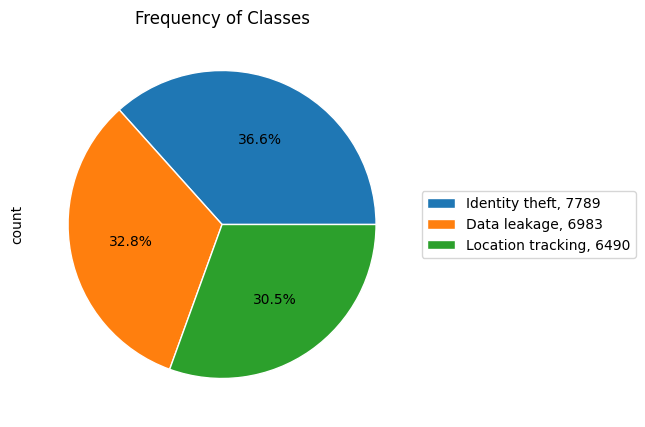

In [ ]:
# df_org["Privacy Issue"].value_counts().plot(kind='pie', figsize=(5,5))



# Count the values
value_counts = df_org["Privacy Issue"].value_counts()

# Plot the pie chart
plt.figure(figsize=(5, 5))
pie_chart = value_counts.plot(kind='pie', labels=['']*len(value_counts), autopct='%1.1f%%', wedgeprops=dict(edgecolor='w'))

# Add value counts to the chart
plt.title('Frequency of Classes')

# Move legend outside of the chart
plt.legend(labels=[f'{label}, {count}' for label, count in value_counts.items()],
           loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

In [ ]:
df_org.shape

(21262, 3)

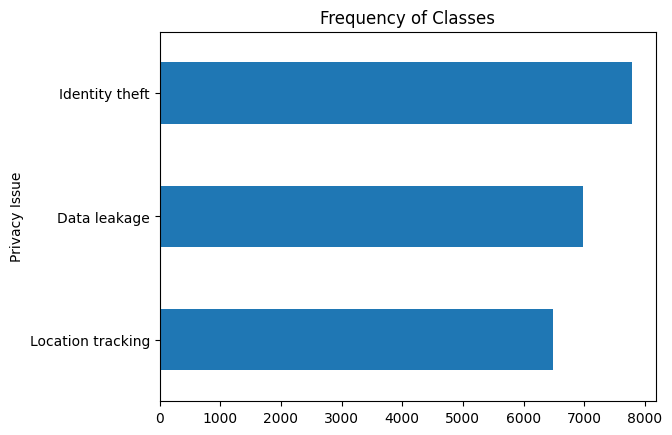

In [ ]:
df_org["Privacy Issue"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased", max_length=512)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=NUM_LABELS, id2label=id2label, label2id=label2id)
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## Useful information and understanding you know about the model from the above output

**Model components:** The model consists of several key components, such as:

* Embeddings (word, position, and token type embeddings)

* Encoder layers (12 layers in this case, each with self-attention, intermediate, and output components)

* Layer normalization and dropout layers for regularization

* GELU activation functions used in the intermediate layers

**Model dimensions:**

* Word embeddings: The model has an embedding size of 768 dimensions and a vocabulary size of 32,000 tokens.

* Position embeddings: The model can handle input sequences of up to 512 tokens in length.

* Encoder layers: The model has 12 encoder layers, each with a hidden size of 768 and an intermediate layer size of 3072.

* Task-specific classification layer: The BertForSequenceClassification model is designed for sequence classification tasks. It takes the final hidden state of the [CLS] token and passes it through a linear layer and a softmax function to produce class probabilities. In this case, the model is configured with a custom number of labels (NUM_LABELS) and label mappings (id2label, label2id).

--------------------------

## Lets understand the flow of a raw input-text > through the pretrained BERT Model > and finally coming out on the other side of the model as a class prediction in the context of this task-specific fine-tuning.

In BERT-based models like BertForSequenceClassification, the [CLS] token (short for "classification") serves as a special token that is prepended to the input sequence. It is designed to be used as an aggregate representation of the entire input sequence for classification tasks.

Here's a step-by-step breakdown of how the [CLS] token is handled during fine-tuning for a specific classification task:

Tokenization: During the pre-processing of the input text, the tokenizer inserts the [CLS] token at the beginning of the input sequence. For example, if the input text is "This is a sample sentence.", the tokenized input would look like: "[CLS] This is a sample sentence."

**Embeddings:** The tokenized input sequence, including the [CLS] token, is passed through the BERT model's embedding layers, which convert the tokens into continuous-valued word vectors.

**Encoder layers:** The embedded input sequence is then processed through the BERT model's encoder layers, which consist of self-attention mechanisms and feed-forward neural networks. During this process, the model learns to capture the semantic and syntactic information present in the input sequence, as well as any relationships between the tokens.

**Final hidden state of [CLS]:** At the end of the BERT model's encoder layers, each token has a corresponding hidden state vector. For the [CLS] token, its final hidden state is used as an aggregated representation of the entire input sequence. This vector is then passed to the task-specific classification layer.

**Linear layer:** The final hidden state of the [CLS] token is fed into a linear layer, which maps the 768-dimensional vector (assuming the base BERT model) to a vector of size equal to the number of target classes. This is essentially a weight matrix multiplication followed by a bias term addition.

**Softmax function:** The output of the linear layer is then passed through a softmax function, which converts the raw output values into class probabilities. The softmax function ensures that the sum of probabilities across all classes equals 1.

**Prediction:** The class with the highest probability is chosen as the final prediction for the given input sequence.

During task-specific fine-tuning, the model learns to adjust its weights and biases based on the training data and the target labels. This involves updating both the BERT model's pre-trained parameters and the task-specific classification layer's parameters through backpropagation and optimization techniques like gradient descent. This fine-tuning process allows the model to adapt to the specific classification task and improve its performance on the given dataset.

-------------------

## In the above task specific fine tuning do all of the weights of the pretrained BERT model gets modified during this finetuning process or only some of the weights get modified ?


During task-specific fine-tuning, all of the weights of the pre-trained BERT model are potentially subject to modification, including the weights in the embedding layers, the encoder layers, and the classification layer. However, the extent to which each weight is modified depends on the learning rate, the specific task, and the training data.

In general, fine-tuning a pre-trained model like BERT involves updating its weights to better adapt to the target task. When fine-tuning begins, the initial weights of the model come from the pre-trained model, which has already learned general language representations from a large-scale unsupervised task (e.g., masked language modeling).

During fine-tuning, the model is exposed to the particular task-specific training data and labels, and the weights are updated using backpropagation and gradient descent.

Typically, the learning rate for fine-tuning is set to be smaller than the learning rate used during pre-training. This is because the pre-trained model already has a good understanding of language, and the fine-tuning process aims to make small, incremental adjustments to the weights to adapt the model to the specific task without losing the valuable general language knowledge.

In [ ]:
df_org.shape[0]
df_org.head(3)

,Learners Perspective,Privacy Issue,labels
13976,I foolishly use my debit card for online purch...,Identity theft,0
1710,Mobile apps associated with the eLearning plat...,Location tracking,1
369,"During the upload of lecture materials, an in...",Location tracking,1


## Splitting df_org


In [ ]:
SIZE= df_org.shape[0]

train_texts= list(df_org['Learners Perspective'][:SIZE//2])

val_texts=   list(df_org['Learners Perspective'][SIZE//2:(3*SIZE)//4 ])

test_texts=  list(df_org['Learners Perspective'][(3*SIZE)//4:])

train_labels= list(df_org.labels[:SIZE//2])

val_labels=   list(df_org.labels[SIZE//2:(3*SIZE)//4])

test_labels=  list(df_org.labels[(3*SIZE)//4:])

In [ ]:
len(train_texts)
len(val_texts)
# val_texts

# val_labels


5315

In [ ]:
SIZE= df_org.shape[0]
SIZE

21262

**SHOWING SOME TABLES HERE**

In [ ]:
# import pandas as pd
# df = df_org["val_texts"][:]
# df.head()


# def label_int2str(row):
# return emotions["train"].features["label"].int2str(row)
# df["label_name"] = df["label"].apply(label_int2str)
# df.head()

In [ ]:
len(train_texts), len(val_texts), len(test_texts)

(10631, 5315, 5316)

In [ ]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings  = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [ ]:
class DataLoader(Dataset):
    """
    Custom Dataset class for handling tokenized text data and corresponding labels.
    Inherits from torch.utils.data.Dataset.
    """
    def __init__(self, encodings, labels):
        """
        Initializes the DataLoader class with encodings and labels.

        Args:
            encodings (dict): A dictionary containing tokenized input text data
                              (e.g., 'input_ids', 'token_type_ids', 'attention_mask').
            labels (list): A list of integer labels for the input text data.
        """
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        """
        Returns a dictionary containing tokenized data and the corresponding label for a given index.

        Args:
            idx (int): The index of the data item to retrieve.

        Returns:
            item (dict): A dictionary containing the tokenized data and the corresponding label.
        """
        # Retrieve tokenized data for the given index
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

        # Add the label for the given index to the item dictionary
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        """
        Returns the number of data items in the dataset.

        Returns:
            (int): The number of data items in the dataset.
        """
        return len(self.labels)


## From above DataLoader() The line `item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}`

Here I use a dictionary comprehension that constructs a new dictionary called `item`. This line converts the encoding values associated with the input text at the given index idx into PyTorch tensors.

self.encodings is a dictionary containing tokenized input text with keys like 'input_ids', 'token_type_ids', and 'attention_mask'. These keys represent different aspects of the encoded text that are needed for processing by the BERT model. The values associated with these keys are lists or arrays of integers.

.items() is a method that returns a view object displaying a list of a dictionary's key-value pairs as tuples.

The dictionary comprehension iterates through the key-value pairs of self.encodings with the variables key and val. For each key-value pair, it creates a new key-value pair in the item dictionary, where the key remains the same, and the value is a PyTorch tensor created from the elements at index idx of the original value.

In essence, this line of code is converting the relevant parts of the input encodings (e.g., input IDs, attention masks) at the given index idx into PyTorch tensors and storing them in a new dictionary called item. This format is necessary for input to the BERT model during training or evaluation.

Here's an example of the output format for self.encodings:


```
{
    'input_ids': [
        [101, 2023, 2003, 1037, 2742, 102],
        [101, 1045, 2066, 5009, 2102, 102],
        [101, 2129, 2024, 2017, 1029, 102]
    ],
    'token_type_ids': [
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]
    ],
    'attention_mask': [
        [1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1]
    ]
}
```

In this example, there are three input sentences, each encoded into three different features: input_ids, token_type_ids, and attention_mask.

* input_ids: Lists of token IDs that represent the input text. The integers correspond to the tokens in the tokenizer's vocabulary.

* token_type_ids: Lists of token type IDs that indicate the type of each token. In this case, they are all 0 since there is only one sentence per input. In tasks that require sentence pairs, you would see different token type IDs for different sentences.

* attention_mask: Lists of binary values that indicate whether a given token should be attended to (1) or not (0). In this example, all tokens are attended to, so all the values are 1. Padding tokens would have a value of 0 in the attention_mask.

Note that this example assumes that the maximum sequence length is 6 tokens, and there's no need for padding or truncation. In practice, you would have longer sequences, and padding would be necessary to make all the input sequences have the same length.

In [ ]:
train_dataloader = DataLoader(train_encodings, train_labels)

val_dataloader = DataLoader(val_encodings, val_labels)

test_dataset = DataLoader(test_encodings, test_labels)

## Training with Trainer Class

In [ ]:
from transformers import TrainingArguments, Trainer

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    """
    Computes accuracy, F1, precision, and recall for a given set of predictions.

    Args:
        pred (obj): An object containing label_ids and predictions attributes.
            - label_ids (array-like): A 1D array of true class labels.
            - predictions (array-like): A 2D array where each row represents
              an observation, and each column represents the probability of
              that observation belonging to a certain class.

    Returns:
        dict: A dictionary containing the following metrics:
            - Accuracy (float): The proportion of correctly classified instances.
            - F1 (float): The macro F1 score, which is the harmonic mean of precision
              and recall. Macro averaging calculates the metric independently for
              each class and then takes the average.
            - Precision (float): The macro precision, which is the number of true
              positives divided by the sum of true positives and false positives.
            - Recall (float): The macro recall, which is the number of true positives
              divided by the sum of true positives and false negatives.
    """
    # Extract true labels from the input object
    labels = pred.label_ids
    # Obtain predicted class labels by finding the column index with the maximum probability
    preds = pred.predictions.argmax(-1)
    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)
    # Return the computed metrics as a dictionary
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }


## compute_metrics

argmax(): The NumPy method argmax() returns the index of the maximum value along a given axis. In a classification problem, we are interested in finding the class with the highest probability for each observation.

(-1): The (-1) inside argmax() represents the axis along which the operation should be performed. In Python, negative indices are used to access elements from the end. So, (-1) here means the last axis, which is the columns in a 2D array.

In [ ]:
logging_steps= len(train_encodings)


training_args = TrainingArguments(
    output_dir='Model',
    do_train=True,
    do_eval=True,
    num_train_epochs=15,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=100,
    weight_decay=0.01,
    logging_strategy='steps',
    logging_dir='multi-class-logs',
    logging_steps=logging_steps,
    evaluation_strategy="epoch",
    eval_steps=50,
    save_strategy="epoch",
    #FP16 mixed precision training with AMP or APEX and FP16 half precision evaluation can only be used on certain types of devices, such as CUDA-enabled GPUs,
    # fp16 should be set to false if you are using CPU.
    fp16=True,
    load_best_model_at_end=True
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer = Trainer(
    # the pre-trained model that will be fine-tuned
    model=model,
     # training arguments that we defined above
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=val_dataloader,
    compute_metrics= compute_metrics
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.574100,0.443324,0.739417,0.737610,0.790381,0.732244
2,0.460200,0.468542,0.733020,0.733472,0.777965,0.733511
3,0.354400,0.434787,0.738476,0.740185,0.765870,0.740769
4,0.456700,0.454319,0.732832,0.733238,0.818344,0.723698
5,0.274200,0.440547,0.732643,0.734037,0.853916,0.722509
6,0.498800,0.439135,0.736971,0.738844,0.763809,0.740073
7,0.320400,0.452175,0.736030,0.735227,0.736319,0.735906
8,0.367700,0.440756,0.733772,0.733920,0.817177,0.724934
9,0.317300,0.443112,0.737723,0.737241,0.764886,0.735242
10,0.334100,0.446357,0.733396,0.733043,0.744249,0.733343


TrainOutput(global_step=4995, training_loss=0.44206419869347496, metrics={'train_runtime': 4279.4777, 'train_samples_per_second': 37.263, 'train_steps_per_second': 1.167, 'total_flos': 4.195738115799552e+16, 'train_loss': 0.44206419869347496, 'epoch': 15.0})

In [ ]:
q=[trainer.evaluate(eval_dataset=df_org) for df_org in [train_dataloader, val_dataloader, test_dataset]]

pd.DataFrame(q, index=["train","val","test"]).iloc[:,:5]

,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.432906,0.747625,0.748258,0.774835,0.752937
val,0.434787,0.738476,0.740185,0.765870,0.740769
test,0.434022,0.730625,0.732160,0.758700,0.734843


**CONFUSION MATRIX**

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=True)
  plt.title("Normalized confusion matrix")
  plt.show()

In [ ]:
# train_texts= list(df_org['Learner Perspective on Privacy'][:SIZE//2])

# val_texts=   list(df_org['Learner Perspective on Privacy'][SIZE//2:(3*SIZE)//4 ])

# test_texts=  list(df_org['Learner Perspective on Privacy'][(3*SIZE)//4:])

# train_labels= list(df_org.labels[:SIZE//2])

# val_labels=   list(df_org.labels[SIZE//2:(3*SIZE)//4])

# test_labels=  list(df_org.labels[(3*SIZE)//4:])

**PLOT THE CONFUSION MATRIX**

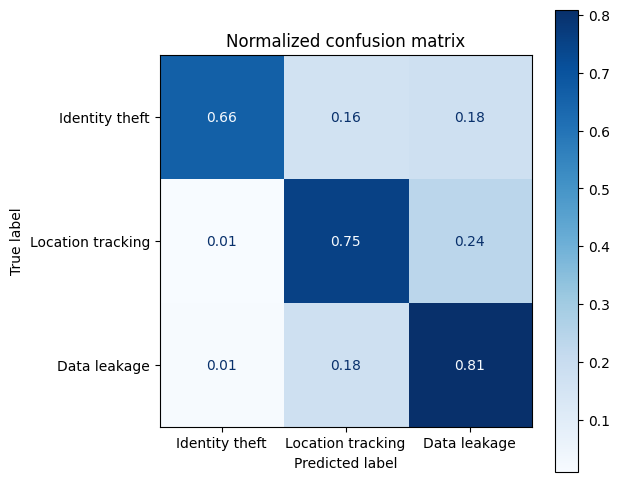

In [ ]:
import numpy as np

preds_output = trainer.predict(val_dataloader)
# preds_output.metrics

y_preds = np.argmax(preds_output.predictions, axis=1)
plot_confusion_matrix(y_preds, val_labels, labels)

**ERROR ANALYSIS**

In [ ]:
df =pd.DataFrame(q)
df

,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
0,0.432906,0.747625,0.748258,0.774835,0.752937,75.4595,140.884,4.413,15.0
1,0.434787,0.738476,0.740185,0.765870,0.740769,37.4429,141.949,4.460,15.0
2,0.434022,0.730625,0.732160,0.758700,0.734843,37.5694,141.498,4.445,15.0


In [ ]:
def label_int2str(row):
  return df["train"].features["label"].int2str(row)

In [ ]:
from torch.nn.functional import cross_entropy
def forward_pass_with_label(batch):
# Place all input tensors on the same device as the model
  inputs = {k:v.to(device) for k,v in batch.items()
  if k in tokenizer.model_input_names}
  with torch.no_grad():
    output = model(**inputs)
    pred_label = torch.argmax(output.logits, axis=-1)
    loss = cross_entropy(output.logits, batch["label"].to(device),
    reduction="none")
  # Place outputs on CPU for compatibility with other dataset columns
  return {"loss": loss.cpu().numpy(),
  "predicted_label": pred_label.cpu().numpy()}
  # Convert our dataset back to PyTorch tensors
  df_org.set_format("torch",columns=["input_ids", "attention_mask", "label"])
# train_dataloader = DataLoader(train_encodings, train_labels)
# val_dataloader = DataLoader(val_encodings, val_labels)
# test_dataset = DataLoader(test_encodings, test_labels)





In [ ]:
for batch in val_dataloader:
    print(batch.items())
    break


dict_items([('input_ids', tensor([  101,  2204,  2851,  3071,  1010,  1045,  1005,  1049,  2559,  2005,
         1037, 14658, 27080,  1045,  2064,  2404,  2006,  2026,  4049,  1012,
         2009,  3791,  2000,  2031,  1037,  6046,  2166,  1997,  2062,  2084,
         1015,  3204,  1010,  2022,  2300, 18907,  1998,  2053,  7058,  2933,
         1012,  2003,  2045,  1037, 14658, 27080,  2008,  2069,  5571,  2033,
         2065,  1045,  2224,  1996,  9651,  2326,  1029,  1045,  1005,  2222,
         2069,  2342,  2000,  4638,  2073,  2026,  4049,  2003,  2065,  1045,
         2131,  2045,  2028,  2154,  1998,  2009,  1005,  1055,  2908,  1012,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,   

In [ ]:
import torch
import torch.nn as nn

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the selected device
model.to(device)


# Define the loss function
criterion = nn.CrossEntropyLoss()

validation_results = []
predicted_labels = []
for batch in val_dataloader:
    # inputs = batch['input_ids']
    # labels = batch['labels']

    inputs = batch['input_ids'].to(device)  # Move inputs to the device
    labels = batch['labels'].to(device)

    # Adjust inputs to be 2D if needed
    if inputs.dim() == 1:
        inputs = inputs.unsqueeze(0)

    # Adjust labels to be 1D if scalar
    if labels.dim() == 0:
        labels = labels.unsqueeze(0)

    # Get model outputs
    outputs = model(inputs)

    # Extract logits from the model outputs
    logits = outputs.logits  # This might vary depending on your model's implementation

    _, predicted_label = torch.max(logits, dim=1) # Get the predicted labels
    predicted_labels.append(predicted_label.item())


    # Compute loss
    loss = criterion(logits, labels)
    validation_results.append(loss.item())

validation_df = pd.DataFrame(validation_results)






We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


In [ ]:


# Convert to actual string labels
predicted_labels = [id2label[label] for label in predicted_labels]

print(predicted_labels)


In [ ]:
# validation_results
# predicted_labels

In [ ]:
df_org = pd.concat([df_org, validation_df], axis=1)

df_org


In [ ]:
actual_labels = [id2label[label] for label in val_labels]

# print(actual_labels)

In [ ]:
import pandas as pd


# Creating a DataFrame
df = pd.DataFrame({'TEXT': val_texts, 'ACTUAL LABEL': actual_labels, 'PREDICTED LABEL':predicted_labels, 'LOSS':validation_results})

# ADD PREDICTED LABEL

# Displaying the DataFrame
# print(df)

COMBINE THE LOSS, ACTUAL LABELS, PREDICTED LABEL, AND TEXT

In [ ]:
styled_df = df.style.set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'center')]}  # Center column names
]).set_properties(**{
    'background-color': 'lightblue',
    'border': '1px solid black',
    'color': 'black',
    'font-size': '12px',
    'text-align': 'left'
})

styled_df

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
val_texts=   list(df_org['Learners Perspective'][SIZE//2:(3*SIZE)//4 ])
# val_texts

In [ ]:
# validation_results

len(validation_results)

# validation_results

5315

In [ ]:
import torch

from torch.nn.functional import cross_entropy
def forward_pass_with_label(batch):
# Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
  if k in tokenizer.model_input_names}
    with torch.no_grad():
      output = model(**inputs)
      pred_label = torch.argmax(output.logits, axis=-1)
      loss = cross_entropy(output.logits, batch["label"].to(device),reduction="none")
    # Place outputs on CPU for compatibility with other dataset columns
      return {"loss": loss.cpu().numpy(),"predicted_label": pred_label.cpu().numpy()}


In [ ]:
# Convert our dataset back to PyTorch tensors
# df_org.set_format("torch",columns=["input_ids", "attention_mask", "label"])

# from datasets import Dataset
# dataset = Dataset.from_pandas(df_org)
# dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])


# Compute loss values
# df_org["validation"] = emotions_encoded["validation"].map(forward_pass_with_label, batched=True, batch_size=16)



# emotions_encoded.set_format("pandas")
# cols = ["text", "label", "predicted_label", "loss"]
# df_test = emotions_encoded["validation"][:][cols]
# df_test["label"] = df_test["label"].apply(label_int2str)
# df_test["predicted_label"] = (df_test["predicted_label"].apply(label_int2str))



In [ ]:
# train_dataloader[0]

# val_dataloader[0]['labels']

# DATA SAMPLE WITH HIGHER LOSES

In [ ]:
df.sort_values("LOSS", ascending=False).head(10)

,TEXT,ACTUAL LABEL,PREDICTED LABEL,LOSS
540,I have a card with something called Kikoff und...,Identity theft,Data leakage,7.961590
4556,I have a card with something called Kikoff und...,Identity theft,Data leakage,7.961590
5040,I have a card with something called Kikoff und...,Identity theft,Data leakage,7.961590
1294,Got these two texts today but never signed up ...,Identity theft,Data leakage,7.807363
428,Got these two texts today but never signed up ...,Identity theft,Data leakage,7.807363
489,and Debt Charities.**,Identity theft,Data leakage,7.596679
188,very difficult and it can lead to a lot of me...,Identity theft,Data leakage,7.534084
1537,very difficult and it can lead to a lot of me...,Identity theft,Data leakage,7.534084
1800,very difficult and it can lead to a lot of me...,Identity theft,Data leakage,7.534084
4631,very difficult and it can lead to a lot of me...,Identity theft,Data leakage,7.534084


#DATA SAMPLE WITH SMALLER LOSSES


In [ ]:
df.sort_values("LOSS", ascending=True).head(10)

,TEXT,ACTUAL LABEL,PREDICTED LABEL,LOSS
4141,On January 3rd of 2024 I got a notification ab...,Identity theft,Identity theft,0.000210
3391,My cousin stole my grandpa’s SSN and used it t...,Identity theft,Identity theft,0.000212
503,Stolen Identity / Cash App\n\nSorry this is lo...,Identity theft,Identity theft,0.000213
2993,Stolen Identity / Cash App\n\nSorry this is lo...,Identity theft,Identity theft,0.000213
2080,Stolen Identity / Cash App\n\nSorry this is lo...,Identity theft,Identity theft,0.000213
3385,Hey guys. Cross post from r/scams. \n\nI recei...,Identity theft,Identity theft,0.000215
1710,When I try to sign up online for accounts that...,Identity theft,Identity theft,0.000215
3012,When I try to sign up online for accounts that...,Identity theft,Identity theft,0.000215
4361,When I try to sign up online for accounts that...,Identity theft,Identity theft,0.000215
2612,"Along with so many fraudulent accounts, SS# ab...",Identity theft,Identity theft,0.000216


In [ ]:
# from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast

In [ ]:
def predict(text):
    """
    Predicts the class label for a given input text
    Args:
        text (str): The input text for which the class label needs to be predicted.
    Returns:
        probs (torch.Tensor): Class probabilities for the input text.
        pred_label_idx (torch.Tensor): The index of the predicted class label.
        pred_label (str): The predicted class label.
    """
    # Tokenize the input text and move tensors to the GPU if available
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to(device)
    # Get model output (logits)
    outputs = model(**inputs)
    probs = outputs[0].softmax(1)
    """ Explanation outputs: The BERT model returns a tuple containing the output logits (and possibly other elements depending on the model configuration). In this case, the output logits are the first element in the tuple, which is why we access it using outputs[0].
    outputs[0]: This is a tensor containing the raw output logits for each class. The shape of the tensor is (batch_size, num_classes) where batch_size is the number of input samples (in this case, 1, as we are predicting for a single input text) and num_classes is the number of target classes.

    softmax(1): The softmax function is applied along dimension 1 (the class dimension) to convert the raw logits into class probabilities. Softmax normalizes the logits so that they sum to 1, making them interpretable as probabilities. """

    # Get the index of the class with the highest probability
    # argmax() finds the index of the maximum value in the tensor along a specified dimension.
    # By default, if no dimension is specified, it returns the index of the maximum value in the flattened tensor.
    pred_label_idx = probs.argmax(1)

    # Now map the predicted class index to the actual class label
    # Since pred_label_idx is a tensor containing a single value (the predicted class index),
    # the .item() method is used to extract the value as a scalar
    pred_label = model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label


In [ ]:
# Test with a an example text in Turkish
# text = "I am dissatisfied with the platform's lack of commitment to user privacy"
# text="Not dissatisfied with the platform's lack of commitment to user privacy"
# text="Machine Learning itself is moving towards more and more automated"
# text="The lack of robust security measures on e-learning platforms exposes users to the risk of identity theft. Malicious actors exploit these vulnerabilities to steal personal information, allowing them to create fake identities for the fraudulent acquisition of educational credentials.Consequently, users' privacy is compromised, and the credibility of e-learning certifications is jeopardized, instilling uncertainty and distrust in the platform."
# text="The lack of robust security measures on e-learning platforms exposes use Malicious actors exploit these vulnerabilities to steal personal information, allowing th for the fraudulent acquisition of educational credentials.Consequently, users' privacy is compromised, and the credibility of e-learning certifications is jeopardized, instilling uncertainty and distrust in the platform."
text="The lack of privacy measures makes me hesitant about continuing with this platform"
predict(text)

(tensor([[0.3603, 0.3334, 0.3064]], device='cuda:0', grad_fn=<SoftmaxBackward0>),
 tensor([0], device='cuda:0'),
 'Identity theft')

## Save model for inference

In [5]:
model_path = "text-classification-model"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

NameError: name 'trainer' is not defined

In [3]:
import os

In [4]:
# print(os.listdir(model_path))

NameError: name 'model_path' is not defined

## Re-Load saved model for inference

In [ ]:
model_path = "text-classification-model"
device = 0 if torch.cuda.is_available() else -1
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer= BertTokenizerFast.from_pretrained(model_path)
nlp= pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, device=device)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


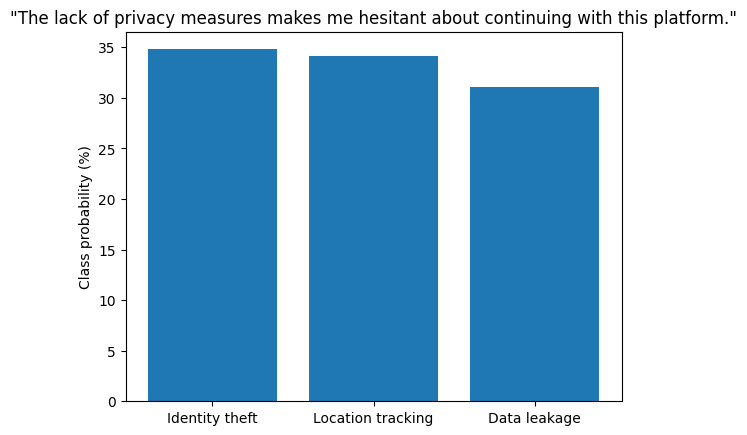

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

custom_tweet = "The lack of privacy measures makes me hesitant about continuing with this platform."

# Get predictions
preds = nlp(custom_tweet, return_all_scores=True)

# Move the tensor to CPU (if it's on a GPU)
# Check if preds is a tensor and convert to CPU if needed
if isinstance(preds[0][0]['score'], torch.Tensor):
    preds = [{k: v.cpu().numpy() if isinstance(v, torch.Tensor) else v for k, v in pred.items()} for pred in preds[0]]
else:
    preds = preds[0]

# Create a DataFrame
preds_df = pd.DataFrame(preds)

# Plotting
labels = preds_df["label"]
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()


**TESTING THE PIPELINE WITH SAMPLE TWEETS**

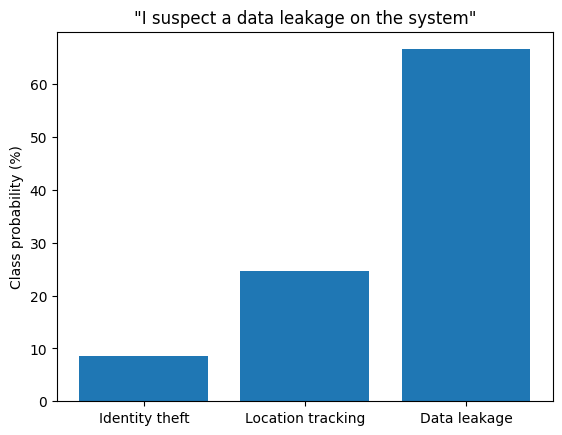

In [ ]:
custom_tweet = "I suspect a data leakage on the system"
preds = nlp(custom_tweet, return_all_scores=True)
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()

In [6]:
nlp("Within e-learning environments designed for children and adolescents, cybercriminals may capitalize on security weaknesses to obtain sensitive personal information, such as birthdates and school affiliations, paving the way for child identity theft. The repercussions of data breaches on minors privacy can be severe, causing long-term harm to victims and their families")
# Today the weather is very nice, I want to go for a walk outside

# Gives below output
#[{'label': 'saglik', 'score': 0.8295329213142395}]
# "Saglik" is a Turkish word that means "health" in English.

NameError: name 'nlp' is not defined

In [ ]:
nlp("The lack of privacy measures makes me hesitant about continuing with this platform")


[{'label': 'Identity theft', 'score': 0.3602502942085266}]

In [ ]:
nlp("Due to recent volatility in the economy, the stock market index has been at quite low levels")

[{'label': 'Data leakage', 'score': 0.5146512389183044}]

In [ ]:
nlp("Data Leakage on the platform is quite alarming")


[{'label': 'Data leakage', 'score': 0.47837531566619873}]

**PLOTS**